## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [47]:
import pickle
with open('/content/all_tokens (3).pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

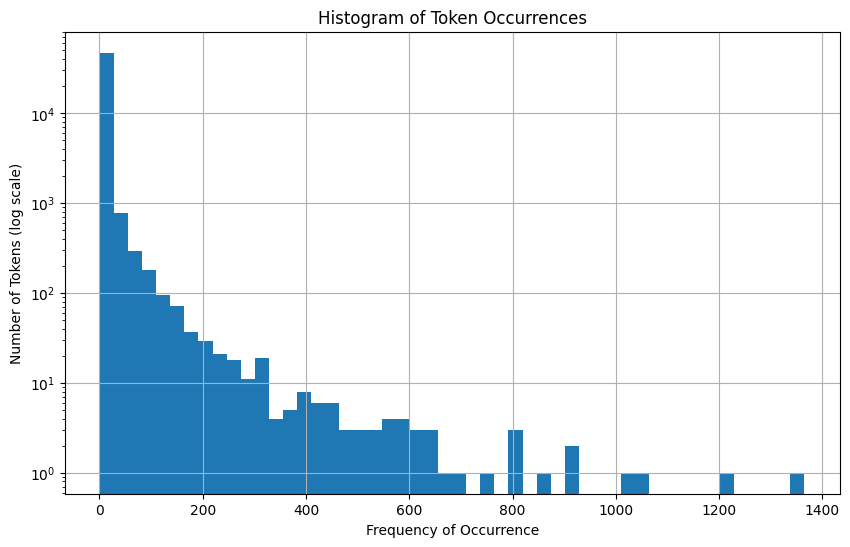

In [48]:
import matplotlib.pyplot as plt

# Extract the frequencies from token_freq
frequencies = [freq for token, freq in token_freq]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(frequencies, bins=50, log=True) # Using log scale for better visualization
plt.title('Histogram of Token Occurrences')
plt.xlabel('Frequency of Occurrence')
plt.ylabel('Number of Tokens (log scale)')
plt.grid(True)
plt.show()

When you look at the histogram of token occurrences, you can that a few tokens show up a lot while most others barely appear This is pretty typial for tet data and usually follows something called a power-law distribution, or Zipf's Law. Basically, the most common words appear way more often than the rest, and their frequency drops sharply as you go down the list. You can really see that steep decline in the histogram from the mmost frequent tokens to the less common ones.

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [52]:
# Question 2.1:
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined from loading the data in the previous step
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# Question 2.2:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df = pd.read_parquet('/content/Phishing_clean (1).parquet')

X = df.drop('Email Type', axis=1)
y = df['Email Type']

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'R-squared on the training set: {r2_train:.4f}')
print(f'R-squared on the test set: {r2_test:.4f}')

R-squared on the training set: 0.7670
R-squared on the test set: 0.6659


In [54]:
# Question 2.3:
import pandas as pd

coefficients = model.coef_
feature_names = X.columns

coef_series = pd.Series(coefficients, index=feature_names)

top_words = coef_series.abs().sort_values(ascending=False).head(10)

print("Words with the largest absolute coefficients:")
print(top_words)

Words with the largest absolute coefficients:
intervention         1.259257
localized            0.824350
thermal              0.747006
crawler              0.696167
background-image:    0.622909
helvetica,           0.598560
aging                0.594956
form.                0.576886
gray;                0.574480
a:active             0.574480
dtype: float64


### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

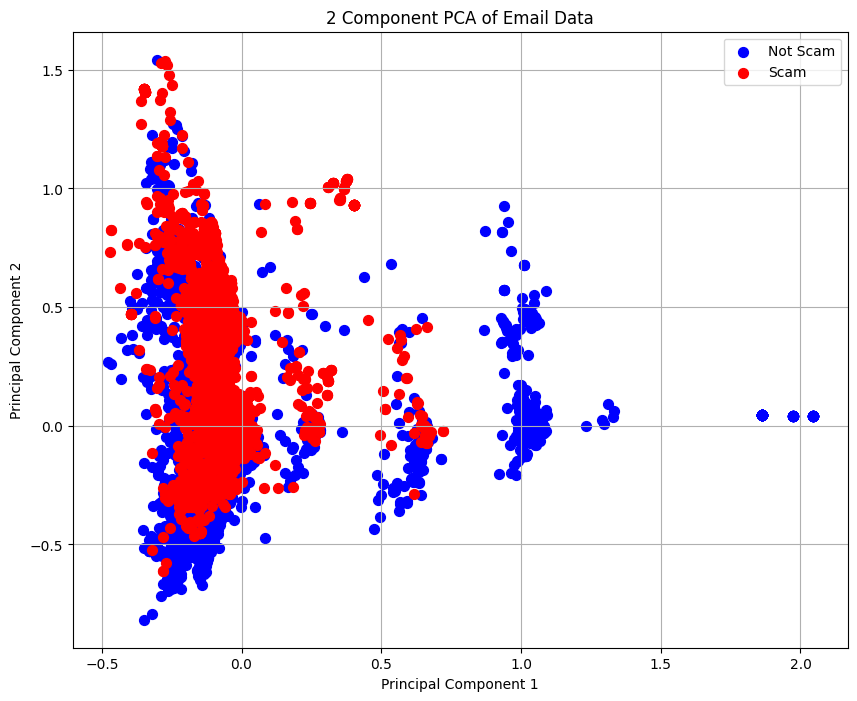

In [58]:
# Question 3:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(data = X_pca, columns = ['principal component 1', 'principal component 2'])
pca_df['Email Type'] = y.reset_index(drop=True)

plt.figure(figsize=(10, 8))
targets = [0, 1]
colors = ['blue', 'red']
for target, color in zip(targets, colors):
    indicesToKeep = pca_df['Email Type'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 Component PCA of Email Data')
plt.legend(['Not Scam', 'Scam'])
plt.grid(True)
plt.show()

When you look at the scatterpllot of the first two prinipal oponents you an kind of see whether the scam (red) and non-scam (blue) emails form their own clusters. If the colors are seperated or grouped in different areas that means these twp components are doing a good job at capturing the differenes between the two types of emails. Even if they're not perfectly split apart you ight still notie patterns like one group being more spread out while the other stays in one section of the plot.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [57]:
# Question 4:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

pca_2610 = PCA(n_components=2610)
X_pca_2610 = pca_2610.fit_transform(X)

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_2610, y, test_size=0.2, random_state=42)

model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)

y_train_pred_pca = model_pca.predict(X_train_pca)
y_test_pred_pca = model_pca.predict(X_test_pca)

r2_train_pca = r2_score(y_train, y_train_pred_pca)
r2_test_pca = r2_score(y_test, y_test_pred_pca)

print(f'R-squared on the training set (PCA): {r2_train_pca:.4f}')
print(f'R-squared on the test set (PCA): {r2_test_pca:.4f}')

R-squared on the training set (PCA): 0.7662
R-squared on the test set (PCA): 0.6684


When comparing the linear regression model on the original data versus the one using PCA, the results are pretty similar overall. For the original data, the R-squared on the training set was {{r2_train:4f}} and the R-sqaured on the test set was {{r2_test:4}}.. For the PCA version (Question 4), the R-squared on the training set was {{r2_train_pca:.4f}}, and on the test set it was {{r2_test_pcca:.4}}. The test R-sqaured went up slightly PCA, but not by much, so it diodnt really akes a big differene. This shows that using the principal components to using all the original features. In other words, PCA helped reduce the dimensionalioty without losing much predictive power.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components instead of the original data for a high-dimensional regression comes with a lot of benefits.

For one, PCA cuts down the number of features by turning all those thousands of variables into a smaller set that still captures most of the most of the important information. That's really helpful when you're working with something huge, like oer 2700 tokens.

It also helps reduce multicollinearity, which basically means some features are too similar to each other and can confuse the model. PCA fixes that by creating new features that arent correlated, which makes the results more reliable.

Another big plus is that it gets rid of noise. The components that dont explain much variance are usually just random noise, so focusing on the main components helps the odel perform better. And since we are working with fewer features it's faster and more efficient to train and test the model.

So even though in this case PCA didn't change the performance that uh, it's still a smart move for high-dimensional data becuase it simplifies the datset, makes the model more stable and speeds things up overall.